In [2]:
import torch
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from hydra.utils import instantiate

from icicl.utils.experiment_utils import extract_config
from icicl.data.on_off_grid import OOTGBatch, SyntheticOOTGGenerator
from icicl.data.gp import RandomScaleGPGenerator

%load_ext autoreload
%autoreload 2

/Users/ericlangezaal/miniforge3/envs/tnp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Trying OOTG Batches!

In [ ]:
OOTGGen = SyntheticOOTGGenerator(
    off_grid_generator=RandomScaleGPGenerator(
        dim=1, 
        kernel_type= "eq", min_log10_lengthscale= -0.602, max_log10_lengthscale= 0.602, noise_std= 0.2,
        num_tasks=2,
        min_num_ctx = 1, max_num_ctx = 64, min_num_trg = 128, max_num_trg = 128,
        context_range = [[-2.0, 2.0]],
        target_range = [[-3.0, 3.0]],
        samples_per_epoch = 16384,
        batch_size = 16
    ),
    grid_range=[[-3.0, 3.0]],
    points_per_unit=8,
    samples_per_epoch = 16000,
    batch_size = 16,
)

In [ ]:
for batch in OOTGGen:
    print(batch.xc_on_grid.shape)
    print(batch.yc_on_grid.shape)
    print(batch.yc_off_grid.shape)
    print(batch.xt.shape)
    break

In [ ]:
from icicl.models.ootg_tnp import OOTGSetConvTNPDEncoder
from icicl.utils.helpers import preprocess_observations
from icicl.utils.conv import flatten_grid, unflatten_grid
from icicl.networks.mlp import MLP

dim = 1
xy_encoder = MLP(in_dim= 3 + dim, out_dim = 5, num_layers = 2, width= 32)

grid_encoder = OOTGSetConvTNPDEncoder(dim=dim, init_lengthscale=2 * 1/ 4, xy_encoder = xy_encoder, transformer_encoder=None)

patch_size = 16
conv = torch.nn.Conv1d(in_channels=5, out_channels=5, kernel_size=patch_size, stride=patch_size)

def coarsen_grid(z: torch.Tensor) -> torch.Tensor:
        
        # z will be of shape (batch, num_on_grid, embed_dim)
        z = unflatten_grid(z, dim=dim)
        # move 'channels' (i.e embed_dim) right after batch
        z = z.movedim(-1, 1)
        z = conv(z)
        # move 'channels' (i.e embed_dim) to end again
        z = z.movedim(1, -1)
        return flatten_grid(z)

for batch in OOTGGen:
    xc, yc = grid_encoder.grid_encode(xc_off_grid=batch.xc_off_grid, yc_off_grid=batch.yc_off_grid, xc_on_grid=batch.xc_on_grid, yc_on_grid=batch.yc_on_grid)
    print(yc.shape)
    yc, yt = preprocess_observations(batch.xt, yc)
    print(yc.shape)
    zc = torch.cat((xc, yc), dim=-1)
    print(zc.shape)
    # So zc is 3 + xdim
    zc = xy_encoder(zc)
    print(zc.shape)
    zc = coarsen_grid(zc)  
    print(zc.shape) 

    zt = torch.cat((batch.xt, yt), dim=-1)
    zt = xy_encoder(zt)
    print(zt.shape)
    break

# Profiling

In [ ]:
config_tnp, _ = extract_config("experiments/configs/thesis/ootg_gp_conv_encoder_tnp.yml", [])
config_vit, _ = extract_config("experiments/configs/thesis/ootg_gp_conv_encoder_vit.yml", [])
pl.seed_everything(config_tnp.misc.seed)
experiment_tnp = instantiate(config_tnp)
experiment_vit = instantiate(config_vit)
pl.seed_everything(experiment_tnp.misc.seed)

In [ ]:
from icicl.utils.experiment_utils import np_loss_fn
import time

tnp = experiment_tnp.model
vit = experiment_vit.model
gen_train = experiment_tnp.generators.train

start = time.time()
for i, batch in enumerate(gen_train):
    #model.encoder.grid_encode(batch.xc_off_grid, batch.yc_off_grid, batch.xc_on_grid, batch.yc_on_grid)
    np_loss_fn(tnp, batch)
    
    if i > 100:
        break

print(f"This took {time.time() - start} seconds")

# ConvSet TNP Encoder Tests

In [ ]:
%load_ext autoreload
%autoreload 2

from icicl.utils.conv import make_grid, flatten_grid, unflatten_grid
import torch 
import math
import einops

grid_range = torch.as_tensor([[-5,5]])
print(grid_range)

batch_shape = torch.Size((2,))

xmin = grid_range[:, 0].repeat(*batch_shape, 1)
xmax = grid_range[:, 1].repeat(*batch_shape, 1)

grid = make_grid(
    xmin = xmin, 
    xmax = xmax, 
    points_per_unit = 4, 
    margin = 0)

print(grid.shape)
print(grid.amin(), grid.amax())





plat = flatten_grid(grid)

onplat = unflatten_grid(plat)


torch.allclose(grid, onplat)


# Plotting 1D: Getting the true log-likelihood

In [ ]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import lightning.pytorch as pl
from hydra.utils import instantiate
from experiments.plot import plot
from icicl.utils.experiment_utils import extract_config

config, config_dict = extract_config("experiments/configs/thesis/ootg_gp_plain_tnp.yml", ["params.ignore_on_grid=False"])
config["generators"]["val"]["samples_per_epoch"] = 16
config["generators"]["off_grid_generator_val"]["num_tasks"] = 2 # TODO change
config["generators"]["off_grid_generator_val"]["task_correlation"] = 0.8
pl.seed_everything(config.misc.seed)
experiment = instantiate(config)
pl.seed_everything(experiment.misc.seed)

batches = []
for batch in tqdm(experiment.generators.val, total=len(experiment.generators.val), desc="Validation"):
        batches.append(batch)


In [ ]:
print(batches[0].xc.shape, batches[0].yc.shape, batches[0].xt.shape, batches[0].yt.shape)

In [ ]:
plot(model=experiment.model, batches=batches, num_fig=1)

# Plotting in 2D

In [ ]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import lightning.pytorch as pl
from hydra.utils import instantiate
from experiments.plot import plot
from icicl.utils.experiment_utils import extract_config

config, config_dict = extract_config("experiments/configs/synthetic_1d/ootg_gp_plain_tnp.yml", 
                                     ["params.dim=2", "params.data_range=[[-4.0, 4.0], [-4.0, 4.0]]", "params.points_per_unit=4"])
config["generators"]["val"]["samples_per_epoch"] = 16
config["generators"]["off_grid_generator_val"]["context_range"] = [[-2.0, 2.0], [-2.0, 2.0]]
#config["generators"]["off_grid_generator_val"]["task_correlation"] = 0.8
pl.seed_everything(config.misc.seed)
experiment = instantiate(config)
pl.seed_everything(experiment.misc.seed)

batches = []
for batch in tqdm(experiment.generators.val, total=len(experiment.generators.val), desc="Validation"):
        batches.append(batch)

In [ ]:
print(batches[0].xc_on_grid.shape)
plot(model=experiment.model, batches=batches, num_fig=1)

# Plotting just the data

In [ ]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from icicl.data.synthetic import SyntheticBatch
from hydra.utils import instantiate
from experiments.plot import plot
from icicl.utils.experiment_utils import extract_config
from icicl.data.gp import MultitaskGPModel

config, config_dict = extract_config("experiments/configs/thesis/ootg_gp_conv_encoder_tnp.yml", ["params.ignore_on_grid=False"])
config["generators"]["val"]["samples_per_epoch"] = 16
config["generators"]["off_grid_generator_val"]["context_range"] = [[-3.0, 3.0]]
pl.seed_everything(config.misc.seed)
experiment = instantiate(config)
pl.seed_everything(experiment.misc.seed)

for batch in experiment.generators.val:
        pass

x_plot = torch.linspace(-5.0, 5.0, 256)[None, :, None]
def plot_with_std(means, stds, color):
    plt.plot(
        x_plot[0,:,0].cpu(),
        means[0, :].cpu(),
        "--",
        color=color,
        lw=1,
    )

    plt.fill_between(
        x_plot[0,:,0].cpu(),  
        means[0, :].cpu() - 2 * stds[0, :].cpu(),  
        means[0, :].cpu() + 2 * stds[0, :].cpu(),
        color=color,
        alpha=0.3,
    )

# Make figure for plotting
fig = plt.figure(figsize=(8.0, 6.0))

# Plot context and target points
plt.scatter(
    torch.concat((batch.xc_off_grid, batch.xt), dim=-2)[0, :, 0].cpu().numpy(),
    torch.concat((batch.yc_off_grid, batch.yt), dim=-2)[0, :, 0].cpu().numpy(),
    c="k",
    label="Task 1",
    s=30,
)

plt.scatter(
    batch.xc_on_grid[0, :, 0].cpu().numpy(),
    batch.yc_on_grid[0, :, 0].cpu().numpy(),
    c="r",
    label="Task 2",
    s=30,
)

with torch.no_grad():
    gt_mean, gt_std, _ = batch.gt_pred(
        xc=batch.xc[:1],
        yc=batch.yc[:1],
        xt=x_plot,
        batch=batch
    )
    # Plot ground truth
    plot_with_std(gt_mean, gt_std, color="k")

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise = batch.gt_pred.noise_std ** 2
    num_off_grid = batch.xc_off_grid.shape[-2]
    xc_labels = torch.concat((
        torch.zeros(num_off_grid, 1),
        torch.ones(batch.xc[:1].shape[-2] - num_off_grid, 1)), 
    ).to(torch.long)
    model = MultitaskGPModel((batch.xc[:1].to(torch.float64), xc_labels), batch.yc[:1].squeeze(-1).to(torch.float64), batch.gt_pred.kernel, likelihood, index_kernel=batch.gt_pred.index_kernel)
    model.eval() 
    outputDist = likelihood(model(x_plot[:1].to(torch.float64), torch.ones(x_plot[:1].shape[-2], 1, dtype=torch.long)))

    plot_with_std(outputDist.mean, outputDist.stddev, color="r")

plt.grid()
plt.xlim((-5.0, 5.0))

y_max = 0.25 + max(gt_mean[0, ...] + 2 * gt_std[0, ...])
y_min = -0.25 + min(gt_mean[0, ...] - 2 * gt_std[0, ...])
y_lim = (y_min.cpu(), y_max.cpu())
plt.ylim(y_lim)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc="upper right", fontsize=20)
plt.tight_layout()

if True:
    plt.savefig("hadamard_gp_data_example.svg")

# MHCA Encoding Approach

In [3]:
%load_ext autoreload
%autoreload 2

import torch

from icicl.networks.attention_layers import MultiHeadCrossAttentionLayer
from icicl.networks.transformer import TNPDTransformerEncoder

emb_dim = 1
mhca_layer = MultiHeadCrossAttentionLayer(embed_dim=emb_dim, num_heads=2, head_dim=3, feedforward_dim=emb_dim)

on_grid = torch.linspace(-1, 1, 4)[None, :, None].repeat(2,1,1)
off_grid = torch.randn(2, 3, emb_dim)

print(on_grid[0])
off_grid[0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
tensor([[-1.0000],
        [-0.3333],
        [ 0.3333],
        [ 1.0000]])


tensor([[-1.3967],
        [ 2.3979],
        [-1.2609]])

In [4]:
# natively find idx's:
for nearest_idx,batch in enumerate(off_grid):
    for vec in batch:
        beste = (on_grid[nearest_idx] - vec).abs().sum(dim=-1).argmin()
        print(f"batch{nearest_idx}: {beste}")

batch0: 0
batch0: 3
batch0: 0
batch1: 2
batch1: 3
batch1: 0


In [5]:
B, U, E = off_grid.shape # 'U'nstructured
S = on_grid.shape[-2] # 'S'tructured

nearest_idx = (
    (off_grid[..., None, :] - on_grid[:, None, ...]).abs().sum(dim=-1).argmin(dim=2)
)
print(nearest_idx)

batch_idx_u = torch.arange(B).unsqueeze(-1).repeat(1, U)
print(batch_idx_u.shape)
u_idx = torch.arange(U).repeat(B, 1)
print(u_idx.shape)

mask = torch.zeros(B, U, S, dtype=torch.long)
mask[batch_idx_u, u_idx, nearest_idx] = 1
mask

tensor([[0, 3, 0],
        [2, 3, 0]])
torch.Size([2, 3])
torch.Size([2, 3])


tensor([[[1, 0, 0, 0],
         [0, 0, 0, 1],
         [1, 0, 0, 0]],

        [[0, 0, 1, 0],
         [0, 0, 0, 1],
         [1, 0, 0, 0]]])

In [6]:
# Matts fasters nearest_idx

grid_shape = torch.Tensor([4])

x_grid_min = on_grid.amin(dim=(0, 1))
x_grid_max = on_grid.amax(dim=(0, 1))
x_grid_spacing = (x_grid_max - x_grid_min) / (grid_shape - 1)

nearest_multi_idx = (off_grid - x_grid_min + x_grid_spacing / 2) // x_grid_spacing
nearest_multi_idx = torch.max(
    torch.min(nearest_multi_idx, grid_shape - 1), torch.zeros_like(grid_shape)
)
strides = torch.flip(
    torch.cumprod(torch.cat((torch.ones((1,)), grid_shape), dim=0), dim=0)[:-1],
    dims=(0,),
)
# (batch_size, n).
nearest_idx2 = (nearest_multi_idx * strides).sum(dim=-1).type(torch.int)

print(nearest_idx2)

tensor([[0, 3, 0],
        [2, 3, 0]], dtype=torch.int32)


In [47]:
max_patch = mask.sum(dim=1).amax() + 1
print("max_patches + 1 =", max_patch)

cumcount_idx = (mask.cumsum(dim=1) - 1)[batch_idx_u, u_idx, nearest_idx]
cumcount_idx

max_patches + 1 = tensor(3)


tensor([[0, 1, 0],
        [0, 0, 0]])

In [64]:
FAKE_TOKEN = -torch.inf
gridded = torch.full((B, S, max_patch, E), FAKE_TOKEN)
gridded[batch_idx_u, nearest_idx, cumcount_idx] = off_grid


batch_idx_s = torch.arange(B).unsqueeze(-1).repeat(1, S)
s_idx = torch.arange(S).repeat(B, 1)

gridded[batch_idx_s, s_idx, -1] = on_grid[batch_idx_s, torch.arange(S)]
gridded

tensor([[[[       -inf,        -inf],
          [       -inf,        -inf],
          [-1.0256e-01,  1.0622e-01]],

         [[ 9.4005e-01,  1.4018e-01],
          [       -inf,        -inf],
          [ 1.4212e+00, -2.1867e-01]],

         [[-5.5087e-01, -6.5441e-01],
          [-4.8465e-01, -3.6942e-01],
          [-5.9837e-01, -1.1300e-01]],

         [[       -inf,        -inf],
          [       -inf,        -inf],
          [ 4.6489e-01, -1.3099e+00]]],


        [[[ 6.3806e-01,  4.7408e-01],
          [       -inf,        -inf],
          [ 2.9946e-01,  9.5577e-01]],

         [[       -inf,        -inf],
          [       -inf,        -inf],
          [-1.0481e+00,  1.0485e+00]],

         [[-2.2274e+00, -2.6151e-01],
          [       -inf,        -inf],
          [-2.5062e+00, -2.5403e-01]],

         [[-4.4233e-01, -8.1962e-01],
          [       -inf,        -inf],
          [ 1.3951e-03,  5.5619e-02]]]])

In [69]:
batch_idx_s2 = torch.arange(B).repeat_interleave(S)
print(batch_idx_s)
print(batch_idx_s2)
s_idx2 = torch.arange(S).repeat(B)
print(s_idx)
print(s_idx2)

tensor([[0, 0, 0, 0],
        [1, 1, 1, 1]])
tensor([0, 0, 0, 0, 1, 1, 1, 1])
tensor([[0, 1, 2, 3],
        [0, 1, 2, 3]])
tensor([0, 1, 2, 3, 0, 1, 2, 3])


In [62]:
gridded2 = torch.full((B * S, max_patch, E), FAKE_TOKEN)
idx_shifter = torch.arange(0, B * S, S).repeat_interleave(U)
gridded2[nearest_idx.flatten() + idx_shifter, cumcount_idx.flatten()] = off_grid[batch_idx_u.flatten(), u_idx.flatten()]

gridded2[torch.arange(B * S), -1] = on_grid[batch_idx_s.flatten(), s_idx.flatten()]
gridded2


tensor([[[       -inf,        -inf],
         [       -inf,        -inf],
         [-1.0256e-01,  1.0622e-01]],

        [[ 9.4005e-01,  1.4018e-01],
         [       -inf,        -inf],
         [ 1.4212e+00, -2.1867e-01]],

        [[-5.5087e-01, -6.5441e-01],
         [-4.8465e-01, -3.6942e-01],
         [-5.9837e-01, -1.1300e-01]],

        [[       -inf,        -inf],
         [       -inf,        -inf],
         [ 4.6489e-01, -1.3099e+00]],

        [[ 6.3806e-01,  4.7408e-01],
         [       -inf,        -inf],
         [ 2.9946e-01,  9.5577e-01]],

        [[       -inf,        -inf],
         [       -inf,        -inf],
         [-1.0481e+00,  1.0485e+00]],

        [[-2.2274e+00, -2.6151e-01],
         [       -inf,        -inf],
         [-2.5062e+00, -2.5403e-01]],

        [[-4.4233e-01, -8.1962e-01],
         [       -inf,        -inf],
         [ 1.3951e-03,  5.5619e-02]]])

In [54]:
import einops

gridded_stacked = einops.rearrange(gridded, "b s m e -> (b s) m e")
gridded_stacked

tensor([[[       -inf,        -inf],
         [       -inf,        -inf],
         [-1.0256e-01,  1.0622e-01]],

        [[ 9.4005e-01,  1.4018e-01],
         [       -inf,        -inf],
         [ 1.4212e+00, -2.1867e-01]],

        [[-5.5087e-01, -6.5441e-01],
         [-4.8465e-01, -3.6942e-01],
         [-5.9837e-01, -1.1300e-01]],

        [[       -inf,        -inf],
         [       -inf,        -inf],
         [ 4.6489e-01, -1.3099e+00]],

        [[ 6.3806e-01,  4.7408e-01],
         [       -inf,        -inf],
         [ 2.9946e-01,  9.5577e-01]],

        [[       -inf,        -inf],
         [       -inf,        -inf],
         [-1.0481e+00,  1.0485e+00]],

        [[-2.2274e+00, -2.6151e-01],
         [       -inf,        -inf],
         [-2.5062e+00, -2.5403e-01]],

        [[-4.4233e-01, -8.1962e-01],
         [       -inf,        -inf],
         [ 1.3951e-03,  5.5619e-02]]])

In [ ]:
torch.equal(gridded_stacked, gridded2)

In [ ]:
stacked_mask_idx = gridded_stacked.sum(-1) == FAKE_TOKEN

att_mask = torch.ones(gridded_stacked.size(0), 1, max_patch, dtype=torch.bool)
att_mask[stacked_mask_idx.unsqueeze(1)] = False
att_mask

In [ ]:
# necessary to not get loads of nans
gridded_stacked[gridded_stacked == FAKE_TOKEN] = 0

In [ ]:
latents = torch.randn(S, E)
latents = latents.repeat(B, 1).unsqueeze(1)
latents.shape

In [ ]:
output_mask = mhca_layer(latents, gridded_stacked, mask=att_mask)
print(output_mask.shape)
#output_mask
output = einops.rearrange(output_mask, "(b s) 1 e -> b s e", b=B)
print(output.shape)
assert output.shape == (B, S, E)

In [ ]:
print(output)

# Speedtest results

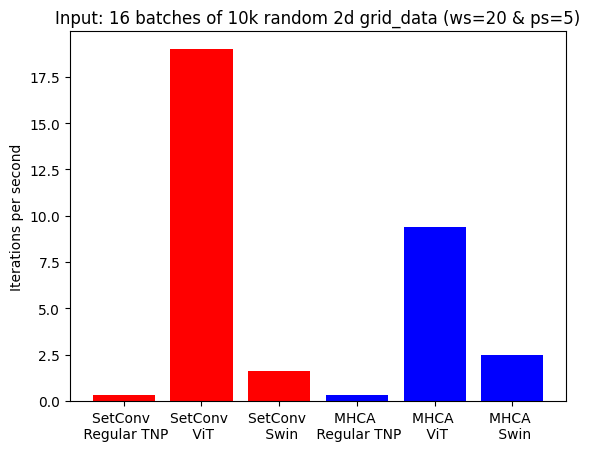

In [1]:
import matplotlib.pyplot as plt

# measured by running untill TQDM iterations stabilizes
# uses Math attention for MHCA Encoder as opposed to mem efficient due to scale issues.

# and 32 off_grid context + 32 targets
results_10k = {"SetConv \n Regular TNP": 0.32,
               "SetConv \n ViT": 19.0, 
               "SetConv \n Swin": 1.6, 
               "MHCA \n Regular TNP": 0.31,
               "MHCA \n ViT": 9.4, 
               "MHCA \n Swin": 2.5} 


plt.bar(results_10k.keys(), results_10k.values(), color=["red"] * 3 + ["blue"] * 3)
plt.ylabel("Iterations per second");
plt.title("Input: 16 batches of 10k random 2d grid_data (ws=20 & ps=5)");

# ERA5 stuff

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import lightning.pytorch as pl
from hydra.utils import instantiate
from experiments.plot_globe import plot_globe
from icicl.utils.experiment_utils import extract_config

config, config_dict = extract_config("experiments/configs/era5/era5_mhca_encoder_swin.yml", ["generators.train.data_dir='data/era5/'", "generators.val.data_dir='data/era5/'"])
experiment = instantiate(config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
batch = experiment.generators.val.generate_batch()
print("xt, yt: ", batch.xt.shape, batch.yt.shape) # context and target do not necessarily make up whole data, depends on max_nt.

print("xc_on_grid, yc_on_grid: ", batch.xc_on_grid.shape, batch.yc_on_grid.shape) 
print("xc_off_grid, yc_off_grid: ", batch.xc_off_grid.shape, batch.yc_off_grid.shape) 


xt, yt:  torch.Size([16, 500, 2]) torch.Size([16, 500, 1])
xc_on_grid, yc_on_grid:  torch.Size([16, 120, 240, 2]) torch.Size([16, 120, 240, 1])
xc_off_grid, yc_off_grid:  torch.Size([16, 598, 2]) torch.Size([16, 598, 1])


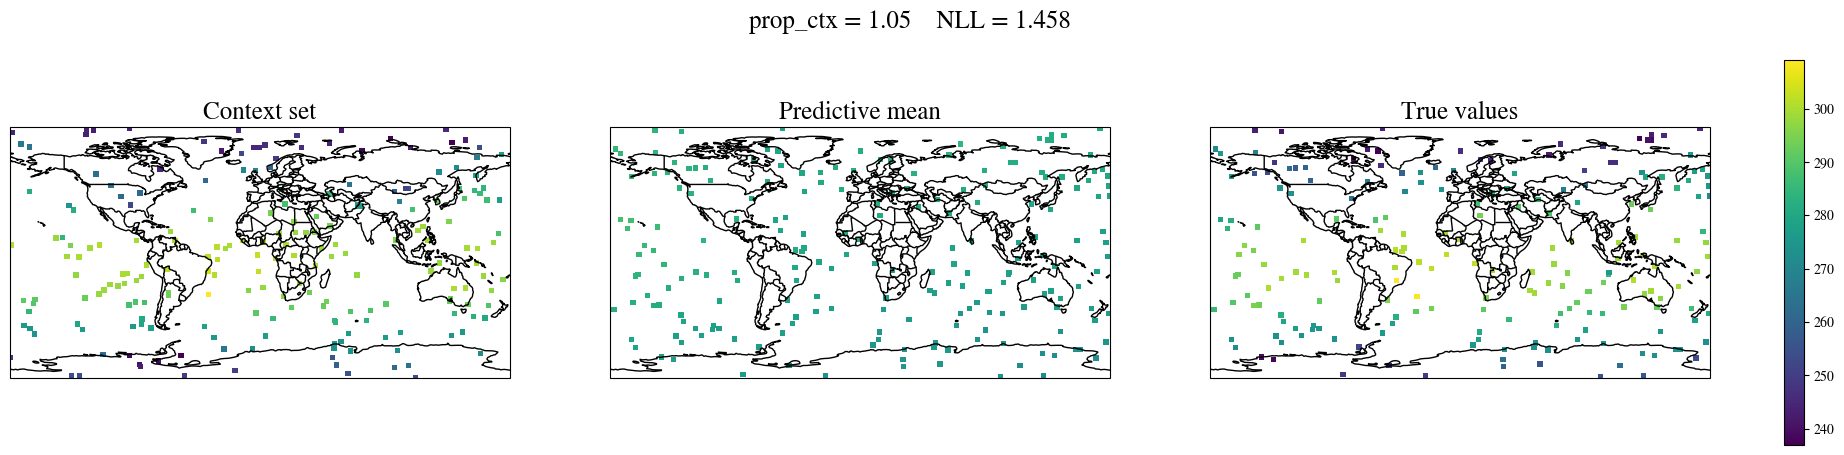

In [5]:
from experiments.plot_globe import plot_globe

batches = [experiment.generators.val.generate_batch()]

plot_globe(
        model=experiment.model,
        batches=batches,
        y_mean=experiment.generators.val.y_mean,
        y_std=experiment.generators.val.y_std,
        num_fig=1,
        figsize=(24.0, 5.0),
        lat_range=experiment.generators.val.lat_range,
        lon_range=experiment.generators.val.lon_range,
        time_idx= None,
        name="test figure",
)

In [13]:
from icicl.utils.grids import flatten_grid
from icicl.utils.conv import compute_eq_weights, haversine_dist

x_grid_flat = flatten_grid(batch.xc_on_grid)
weights = compute_eq_weights(x_grid_flat, batch.xc_off_grid, torch.as_tensor([1]), haversine_dist)


torch.Size([16, 28800, 1, 2]) torch.Size([16, 1, 1302, 2])
torch.Size([16, 28800, 1302, 1])
torch.Size([16, 28800, 1, 2]) torch.Size([16, 1, 1302, 2])
